# Scheduling quantum operations
In this notebook we will cover the QGym `Scheduling` environment.

This environment is aimed at finding the shortest possible schedules of operations defined by random quantum circuits, whilst taking hardware constraints and commutation rules into account.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from IPython.display import clear_output

from qgym.custom_types import Gate
from qgym.envs.scheduling import *

In [ ]:
def render_rgb(step, rgb_array):
    """
    Convenience method that we will use later on to display our results.
    """
    clear_output(wait=True)
    plt.figure(figsize=(40, 20))
    plt.title(f"Step {step}", fontsize=40)
    plt.imshow(rgb_array)
    plt.axis("off")
    plt.show()

### Circuits

The scheduling problem consist of scheduling the operations described by a quantum circuit. 
In this model, a quantum circuit is defined as a list of gates, where a gate is a `namedtuple` with a `name`, `q1` and `q2`.
For example, a c-not with control qubit 2 and target qubit 5 would be `Gate("cnot", 2, 5)` and a X gate acting on qubit 4 would be `Gate("x", 4, 4)`.
In this representation, the circuit below is given by `[Gate("x", 1, 1), Gate("cnot", 0, 1), Gate("x", 0, 0), Gate("h", 1, 1)]`.
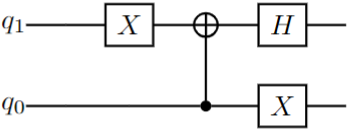


###  Hardware specifications

Different operations defined by a quantum circuit have different operation times.
These operation times are defined in the unit of machine cycles.
For example, a X gate could take 2 machine cycles, whereas a measurement could take 15 cycles.
These different operation times must be taken into account, because we cannot perform multiple operations on the same qubit at the same time.

Finding an optimal schedule with these restriction is already a difficult task.
However, to complicate matters there are also certain limitations defined by the hardware.
To be more concrete, we take two types of limitations into account:

1. Some gates must start at the same time, or must wait till the previous one is finished. This is typically the case for measurements.
2. Some gates can't be executed in the same cycle. This for example happens often with X, Y and Z gates.


The goal of this scheduling problem is to find an optimal schedule which takes these hardware limitations into account, as well as some optional commutation rules.

### Toy hardware

To explain this concept in more detail we start by defining a some toy hardware specifications.


In [ ]:
hardware_spec = MachineProperties(n_qubits=2)
hardware_spec.add_gates({"x": 2, "y": 2, "cnot": 4, "measure": 10})
hardware_spec.add_same_start(["measure"])
hardware_spec.add_not_in_same_cycle([("x", "y")])
print(hardware_spec)

### `Scheduling` environment

The `Scheduling` environment can be initialized by providing:
- hardware specifications; and
- a maximum circuit length, measured in the total number of gates of the circuit.

In [ ]:
env = Scheduling(hardware_spec, max_gates=5, random_circuit_mode="workshop")

#### State space
The state space is described by a dictionary with the following structure:

- `machine_properties`: MachineProperties object containing machine properties and limitations.
- `utils`: ``SchedulingUtils`` dataclass with a random circuit generator, commutation rulebook and a gate encoder.
- `gates`: Dictionary with gate names as keys and ``GateInfo`` dataclasses as values.
- `steps_done`: Number of steps done since the last reset.
- `cycle`: Current 'machine' cycle.
- `busy`: Used internally for the hardware limitations.
- `circuit_info`: ``CircuitInfo`` dataclass containing the encoded circuit and attributes used to update the state.

### To Do
Take a look at the state space in the code block below.

In [ ]:
env.reset()
print(env._state)

#### Observation space

Each element in the observation space is a dictionary with 2 entries:
- `gate_names`: Gate names of the encoded circuit.
- `acts_on`: q1 and q2 of each gate.
- `dependencies`: Shows the first $n$ gates that must be scheduled before this gate.
- `legal_actions`: List of legal actions. If the value at index  $i$  determines if gate number $i$ can be scheduled or not.

### To Do
Use the code block below to take a look at the observation space and see what the `reset` method returns.

In [ ]:
print(env.observation_space)
print()
print(env.reset())

#### Action space

Performing a quantum operation takes a certain amount of time, which will be measured in (machine) cycles.
Therefore, this environment  aims to produces a schedule in terms of cycles.
To do this, the  environment  schedules the circuit from right to left, so cycle zero in the schedule is the last operation to be performed in that schedule.
Based on this idea, a valid action is then a tuple of an integer $i\in\{0,1,\ldots,$ `max_gates`$\}$ and a binary value $j$.
The integer value $i$ schedules gate $i$ in the current cycle and the binary value $j$ increment the cycle number.

If the action is illegal (for example when we try to schedule a gate that has been scheduled already), then the environment will do nothing and the rewarder should give a penalty for this.

### To Do
Take a look at the action space in the code block below.

In [ ]:
print(env.action_space)

#### Rewarders

We have pre-defined 2 different rewarders, which return a penalty when an illegal action is attempted, for a valid action their behavior is as follows:


- `BasicRewarder`: Every step gives a reward.
- `EpisodeRewarder`: Only the final step results in a reward.

Both rewarders can be tweaked by altering either of their parameters:

- `illegal_action_penalty`: penalty given for attempting an illegal action (should be non-positive)
- `update_cycle_penalty`: penalty given for incrementing the cycle (should be non-positive)
- `schedule_gate_bonus`: reward given for scheduling a gate (should be non-negative) (`BasicRewarder` only)

<br/>
<br/>
<br/>
<br/>

### Reinforcement learning

Can we achieve useful schedules with reinforcement learning?

Does changing the rewarder and/or its parameter give better results?

### To Do
Use the first code block to use your favorite rewarder.
Next, use the second code block to train an agent.

In [ ]:
env.rewarder = BasicRewarder(illegal_action_penalty=-5)

In [ ]:
check_env(env, warn=True)

model = PPO("MultiInputPolicy", env, verbose=1)

model.learn(int(1e5))
model.save("scheduling_1")

Let's give it the circuit below and see what kind of schedule the agent produces.

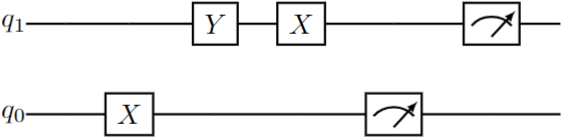

### To Do
Implement the circuit in the first code block.
Use the second code block to see how well the agent schedules the circuit.

In [ ]:
circuit = [
    Gate("x", 0, 0),
    Gate("y", 1, 1),
    Gate("x", 1, 1),
    Gate("measure", 0, 0),
    Gate("measure", 1, 1),
]

In [ ]:
model = PPO.load("scheduling_1")
obs = env.reset(circuit=circuit)
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break

Let's also try some randomly generated circuits.

In [ ]:
obs = env.reset()
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env.step(action)
    render_rgb(i, env.render(mode="rgb_array"))
    if done:
        break

### Commutation Rules
Taking machine properties into account already makes the scheduling problem very difficult to solve.
Even so, the resulting schedules still don't provide a true optimal schedule
For example, commutation rules can also be taken into account.
Under the hood of this environment, two very basic 'commutation rules' are already taken into account:
1. If two gates are exactly equal (same gate, same control qubit and same target qubit), then they commute.
2. If two gates don't have any qubits in common (the gates are disjoint), then they commute.

However, it is possible to extend the logic of the commutation rules by providing a custom commutation `CommutationRulebook` when initializing the environment.
By default, the `Rulebook` already takes into account the two rules above, but can be set to also take more rules into account.
To do this, we must provide a `callable` (function) which takes as input two gates and as output a Boolean value.

Let's try to implement the following commutation rule:
 - A c-not gate and a X gate commute if the X gates acts on the same qubit as the target of the c-not.
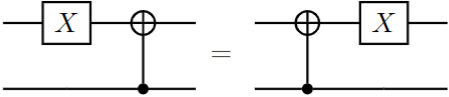



To start we import and initialize the `CommutationRulebook`

In [ ]:
from qgym.envs.scheduling.rulebook import CommutationRulebook

rulebook = CommutationRulebook()

Next we make the rule and add it to the `CommutationRulebook`.
Remember that a gate is `namedtuple` with `name`, `q1` (control qubit) and `q2` (target qubit).

### To Do
Use the code block below to implement the commutation rule.

In [ ]:
def cnot_x_commutation(gate1, gate2):
    if gate1.name == "cnot" and gate2.name == "x":
        if gate1.q2 == gate2.q1:
            return True

    if gate1.name == "x" and gate2.name == "cnot":
        if gate1.q1 == gate2.q2:
            return True

    return False


rulebook.add_rule(cnot_x_commutation)

Finally we add the `CommutationRulebook` to a new `Scheduling` environment and we train a new agent.

### To Do
Use the first code block to pick your favorite rewarder.
Next, use the second code block to train an agent.

In [ ]:
env_com = Scheduling(
    hardware_spec,
    max_gates=5,
    rulebook=rulebook,
    random_circuit_mode="workshop",
)

env_com.rewarder = BasicRewarder(illegal_action_penalty=-5)

In [ ]:
check_env(env, warn=True)

model_com = PPO("MultiInputPolicy", env, verbose=1)

model_com.learn(int(1e5))
model.save("scheduling_2")

Let's see how well what kind of schedule the agent makes for the circuit below.
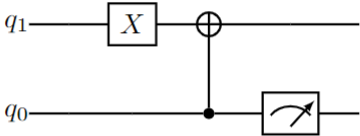

### To Do
Use the first code block to implement the circuit.
Use the second code block to see if the agent uses the new commutation rule.

In [ ]:
circuit = [Gate("x", 1, 1), Gate("cnot", 0, 1), Gate("measure", 0, 0)]

In [ ]:
model = PPO.load("scheduling_2")
obs = env_com.reset(circuit=circuit)
for i in range(1000):
    action, states = model.predict(obs, deterministic=False)
    obs, rewards, done, info = env_com.step(action)
    render_rgb(i, env_com.render(mode="rgb_array"))
    if done:
        break